In [29]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, classification_report,confusion_matrix, f1_score
import glob
import os
import matplotlib.pyplot as plt

In [30]:
# train_path = max(glob.glob('./data/twitter_data_train/*.csv'), key=os.path.getctime) 
# test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv('./data/twitter_data_train_multiclass.csv')
test_df = pd.read_csv('./data/twitter_data_test_multiclass.csv')

print(train_df.shape)
print(test_df.shape)

(9446, 237)
(1667, 237)


In [31]:
to_drop = ['screen_name', 'url', 'profile_image_url', 'description',
           'id', 'name', 'account_type','account_type_multi', 'tweets_list', 'tweets_list_processed',
          'description_processed', 'protected', 'verified', 'Unnamed: 0']

X_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
X_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']

In [32]:
# Combine train and test data set tgt
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [33]:
print(y.value_counts())

3    3426
1    3166
0    2751
2    1770
Name: account_type_multi, dtype: int64


In [34]:
# Check if dataset is balanced
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9446, 223)
(9446,)
(1667, 223)
(1667,)


In [7]:
#Default model
model_xgboost_default = xgb.XGBClassifier(objective='multi:softprob')

model_xgboost_default.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=[(X_test, y_test)],
                  verbose=True)

xgb_train_default_predict = model_xgboost_default.predict(X_train)
xgb_test_default_predict = model_xgboost_default.predict(X_test)


c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:0.88096
[1]	validation_0-mlogloss:0.62009
[2]	validation_0-mlogloss:0.45534
[3]	validation_0-mlogloss:0.34420
[4]	validation_0-mlogloss:0.26660
[5]	validation_0-mlogloss:0.21043
[6]	validation_0-mlogloss:0.16946
[7]	validation_0-mlogloss:0.13987
[8]	validation_0-mlogloss:0.11781
[9]	validation_0-mlogloss:0.10204
[10]	validation_0-mlogloss:0.09076
[11]	validation_0-mlogloss:0.08233
[12]	validation_0-mlogloss:0.07649
[13]	validation_0-mlogloss:0.07175
[14]	validation_0-mlogloss:0.06852
[15]	validation_0-mlogloss:0.06555
[16]	validation_0-mlogloss:0.06337
[17]	validation_0-mlogloss:0.06241
[18]	validation_0-mlogloss:0.06188
[19]	validation_0-mlogloss:0.06127
[20]	validation_0-mlogloss:0.06064
[21]	validation_0-mlogloss:0.05991
[22]	validation_0-mlogloss:0.06000
[23]	validation_0-mlogloss:0.05968
[24]	validation_0-mlogloss:0.05979
[25]	validation_0-mlogloss:0.06011
[26]	validation_0-mlogloss:0.06002
[27]	validation_0-mlogloss:0.05984
[28]	validation_0-mlogloss:0.0

In [8]:
print(model_xgboost_default.get_params)

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)>


**Evaluate Model Performance**

In [9]:
print(confusion_matrix(y_train, xgb_train_default_predict))
print(classification_report(y_train, xgb_train_default_predict))

[[2337    1    0    0]
 [   0 2706    0    0]
 [   1    0 1493    0]
 [   0    0    0 2908]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2338
           1       1.00      1.00      1.00      2706
           2       1.00      1.00      1.00      1494
           3       1.00      1.00      1.00      2908

    accuracy                           1.00      9446
   macro avg       1.00      1.00      1.00      9446
weighted avg       1.00      1.00      1.00      9446



In [10]:
print(confusion_matrix(y_test, xgb_test_default_predict))
print(classification_report(y_test, xgb_test_default_predict))

[[408   0   2   3]
 [  2 457   0   1]
 [  6   0 270   0]
 [ 13   0   0 505]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       413
           1       1.00      0.99      1.00       460
           2       0.99      0.98      0.99       276
           3       0.99      0.97      0.98       518

    accuracy                           0.98      1667
   macro avg       0.98      0.98      0.98      1667
weighted avg       0.98      0.98      0.98      1667



**Hyperparameter Tuning**

In [21]:
learning_rate_list = [0.1, 0.3, 0.5]
max_depth_list = [2, 3, 5]
n_estimators_list = [50, 100, 150]
subsample_list = [0.5, 0.7, 1]


params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               "subsample": subsample_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

81


{'learning_rate': [0.1, 0.3, 0.5],
 'max_depth': [2, 3, 5],
 'n_estimators': [50, 100, 150],
 'subsample': [0.5, 0.7, 1]}

In [23]:
# Custom cross-validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

model_xgboost_tuning = RandomizedSearchCV(estimator=xgb.XGBClassifier(),
                                param_distributions = params_dict,
                                cv=cv_method,
                                scoring='f1_weighted',
                                n_iter = 100,
                                verbose=2,
                                random_state=2022)

model_xgboost_tuning.fit(X, y)

c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 81 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   2.8s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.8s
[CV] END learnin

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=No...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5],
                                        'max_depth': [2, 3, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.5, 0.7, 1]},
                   random_state=2022, scoring='f1_weighted', verbose=2)

In [24]:
model_xgboost_tuning.best_params_

{'subsample': 1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.5}

In [26]:
results_df = pd.DataFrame(model_xgboost_tuning.cv_results_)
results_df = results_df[['rank_test_score','mean_test_score', 'param_subsample',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df.sort_values(by='rank_test_score', inplace=True)
results_df[:10]

,rank_test_score,mean_test_score,param_subsample,param_learning_rate,param_max_depth,param_n_estimators
59,1,0.991403,1,0.5,2,100
62,2,0.991313,1,0.5,2,150
35,3,0.991224,1,0.3,2,150
68,4,0.991224,1,0.5,3,100
34,5,0.991194,0.7,0.3,2,150
44,6,0.991166,1,0.3,3,150
71,7,0.991044,1,0.5,3,150
60,8,0.991044,0.5,0.5,2,150
53,9,0.990986,1,0.3,5,150
52,10,0.990985,0.7,0.3,5,150


## Final Model
Using best parameters from above step

In [35]:
import time
from sklearn.metrics import f1_score

model_xgboost_fin = xgb.XGBClassifier(subsample = 1, n_estimators= 100, max_depth= 2, learning_rate= 0.5)
start_time = time.time()

model_xgboost_fin.fit(X_train, y_train, verbose =True)
y_pred_test = model_xgboost_fin.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test, digits=5))
# roc_auc_score(y_test, y_pred_test)
f1_score(y_test, y_pred_test, average='weighted')

Total time taken for the program execution 4.073385000228882
[[409   0   2   2]
 [  0 460   0   0]
 [  5   0 271   0]
 [ 12   0   0 506]]
              precision    recall  f1-score   support

           0    0.96009   0.99031   0.97497       413
           1    1.00000   1.00000   1.00000       460
           2    0.99267   0.98188   0.98725       276
           3    0.99606   0.97683   0.98635       518

    accuracy                        0.98740      1667
   macro avg    0.98721   0.98726   0.98714      1667
weighted avg    0.98768   0.98740   0.98745      1667



0.9874477155843061

In [36]:
var_colums = [c for c in X_train.columns if c not in ['state']]

df_var_imp = pd.DataFrame({"Feature": var_colums,
                           "Importance": model_xgboost_fin.feature_importances_})\
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

,Feature,Importance
34,tweets_13,0.367250
3,favourites_count,0.070999
14,following_to_followers_ratio,0.070483
12,tweet_weekend_frequency,0.068078
44,tweets_23,0.060178
167,description_46,0.055087
72,tweets_51,0.042444
13,tweet_weekday_frequency,0.024346
40,tweets_19,0.020856
9,tweet_frequency,0.019077


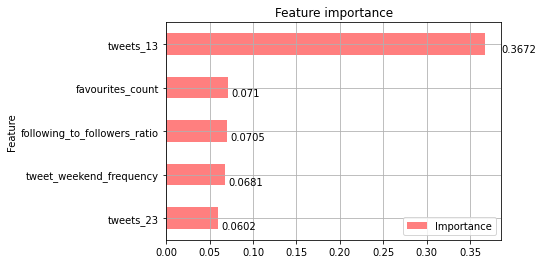

In [37]:
top_5_features = df_var_imp[:5].sort_values('Importance').set_index('Feature')
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 4))
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))

                              Importance
Token                                   
tweets_23: "essere"             0.060178
tweet_weekend_frequency         0.068078
following_to_followers_ratio    0.070483
favourites_count                0.070999
tweets_13: "cool"               0.367250


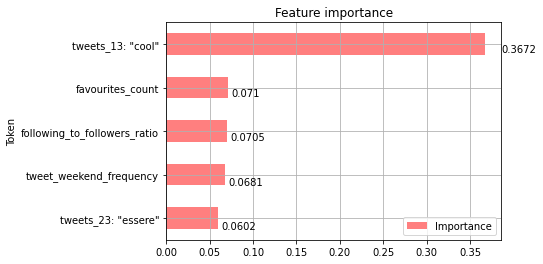

In [41]:
top_5_features['Token'] = ['tweets_23: "essere"', 'tweet_weekend_frequency', 'following_to_followers_ratio', 'favourites_count', 'tweets_13: "cool"']
top_5_features = top_5_features.set_index('Token')
print(top_5_features)
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 4))
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))

In [39]:
import pickle
with open('./data/tfidf_feature_names.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [40]:
print(loaded_dict)

{'tweets': [(0, 'al'), (1, 'always'), (2, 'amp'), (3, 'anche'), (4, 'back'), (5, 'best'), (6, 'cant'), (7, 'che'), (8, 'check'), (9, 'chi'), (10, 'ci'), (11, 'come'), (12, 'con'), (13, 'cool'), (14, 'da'), (15, 'day'), (16, 'de'), (17, 'dei'), (18, 'del'), (19, 'della'), (20, 'di'), (21, 'dont'), (22, 'e'), (23, 'essere'), (24, 'get'), (25, 'gli'), (26, 'go'), (27, 'going'), (28, 'good'), (29, 'got'), (30, 'great'), (31, 'great introduction'), (32, 'ha'), (33, 'history'), (34, 'ho'), (35, 'il'), (36, 'im'), (37, 'introduction'), (38, 'io'), (39, 'know'), (40, 'la'), (41, 'le'), (42, 'learn'), (43, 'life'), (44, 'like'), (45, 'lo'), (46, 'lol'), (47, 'look'), (48, 'love'), (49, 'mai'), (50, 'make'), (51, 'man'), (52, 'mi'), (53, 'money'), (54, 'much'), (55, 'na'), (56, 'need'), (57, 'never'), (58, 'new'), (59, 'non'), (60, 'one'), (61, 'people'), (62, 'per'), (63, 'perch'), (64, 'pi'), (65, 'quando'), (66, 'read'), (67, 'read history'), (68, 'really'), (69, 'right'), (70, 'say'), (71, '